In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 1) Data

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = dict(zip(stoi.values(), stoi.keys()))
vocab_size = len(stoi)

In [4]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# 2) Problem 1 - Initial logits are too high

In [42]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),           generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden),                     generator=g)
W2 = torch.randn((n_hidden, vocab_size),         generator=g)
b2 = torch.randn((vocab_size),                   generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [43]:
batch_size = 32

# minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pas
emb = C[Xb]
emb_cat = emb.view(emb.shape[0], block_size*n_embed)
h = torch.tanh(emb_cat @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yb)

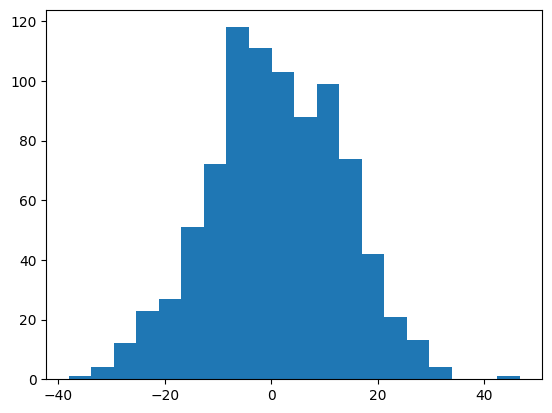

In [44]:
plt.hist(logits.view(-1).tolist(), bins=20);

In [45]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),           generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden),                     generator=g)
W2 = torch.randn((n_hidden, vocab_size),         generator=g).__mul__(0.01)
b2 = torch.randn((vocab_size),                   generator=g).__mul__(0.0)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [46]:
batch_size = 32

# minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pas
emb = C[Xb]
emb_cat = emb.view(emb.shape[0], block_size*n_embed)
h = torch.tanh(emb_cat @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yb)

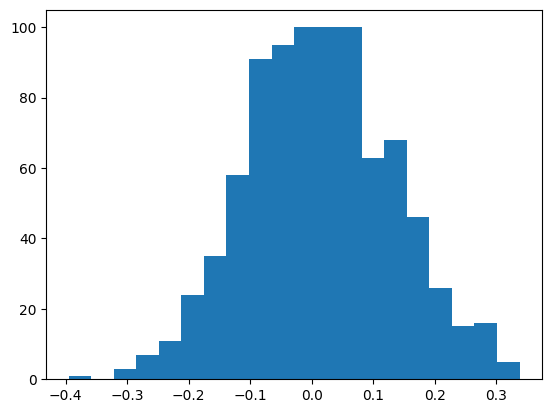

In [47]:
plt.hist(logits.view(-1).tolist(), bins=20);

# 3) Problem 2 - Tanh is being saturated 

In [48]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),           generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden),                     generator=g)
W2 = torch.randn((n_hidden, vocab_size),         generator=g).__mul__(0.01)
b2 = torch.randn((vocab_size),                   generator=g).__mul__(0.0)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [49]:
batch_size = 32

# minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pas
emb = C[Xb]
emb_cat = emb.view(emb.shape[0], block_size*n_embed)
h_pre = emb_cat @ W1 + b1
h = torch.tanh(h_pre)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yb)

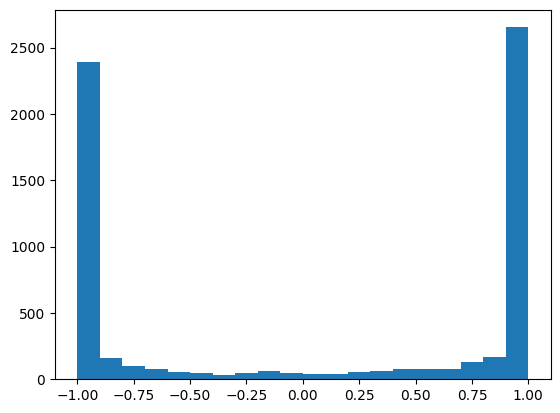

In [50]:
plt.hist(h.view(-1).tolist(), bins=20);

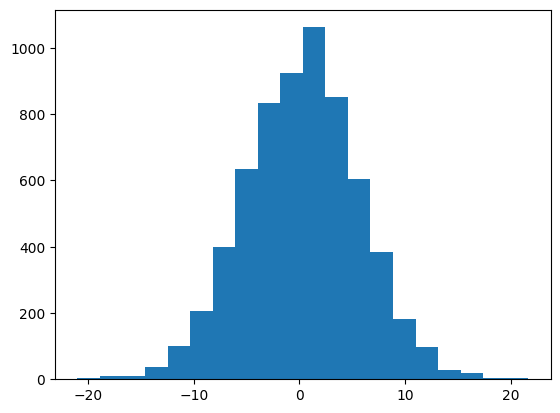

In [51]:
plt.hist(h_pre.view(-1).tolist(), bins=20);

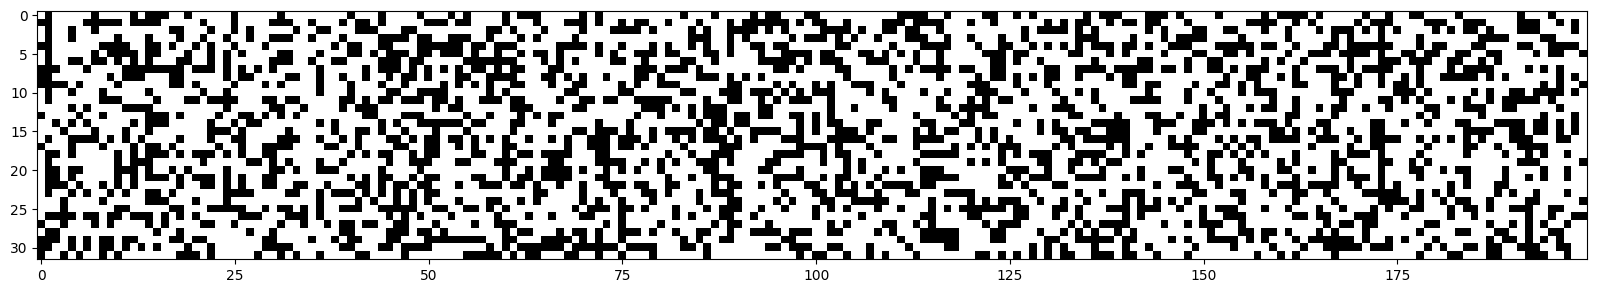

In [52]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

In [53]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),           generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g).__mul__(0.2)
b1 = torch.randn((n_hidden),                     generator=g).__mul__(0.01)
W2 = torch.randn((n_hidden, vocab_size),         generator=g).__mul__(0.01)
b2 = torch.randn((vocab_size),                   generator=g).__mul__(0.0)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [54]:
batch_size = 32

# minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pas
emb = C[Xb]
emb_cat = emb.view(emb.shape[0], block_size*n_embed)
h_pre = emb_cat @ W1 + b1
h = torch.tanh(h_pre)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yb)

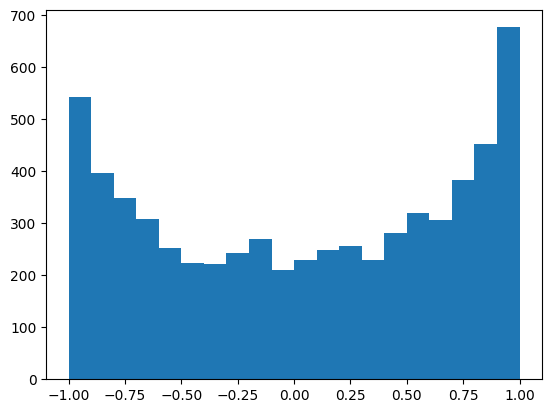

In [55]:
plt.hist(h.view(-1).tolist(), bins=20);

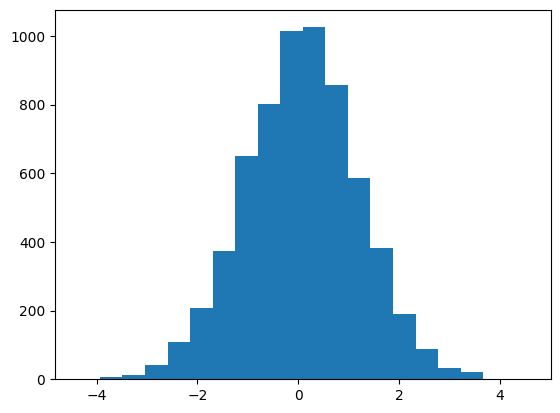

In [56]:
plt.hist(h_pre.view(-1).tolist(), bins=20);

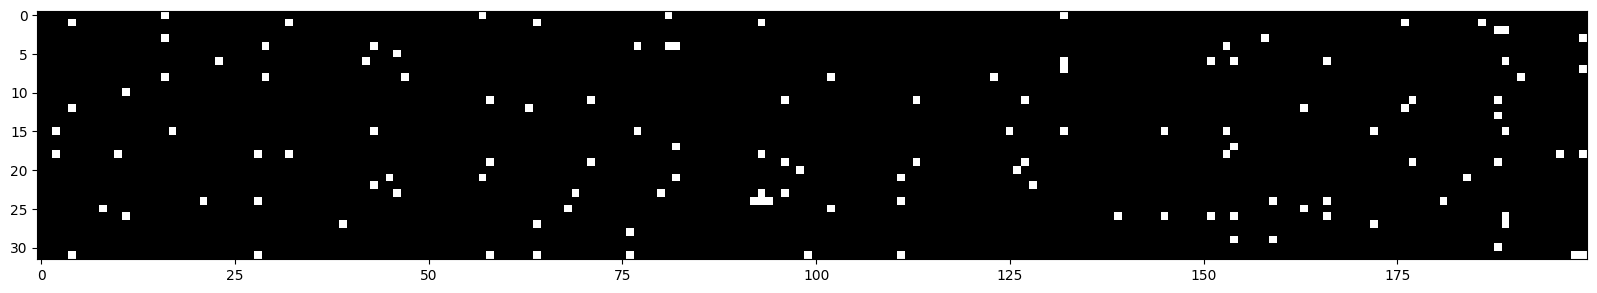

In [57]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

# 4) Kaiming initialization

tensor(-0.0012) tensor(1.0020)
tensor(-0.0013) tensor(3.1588)


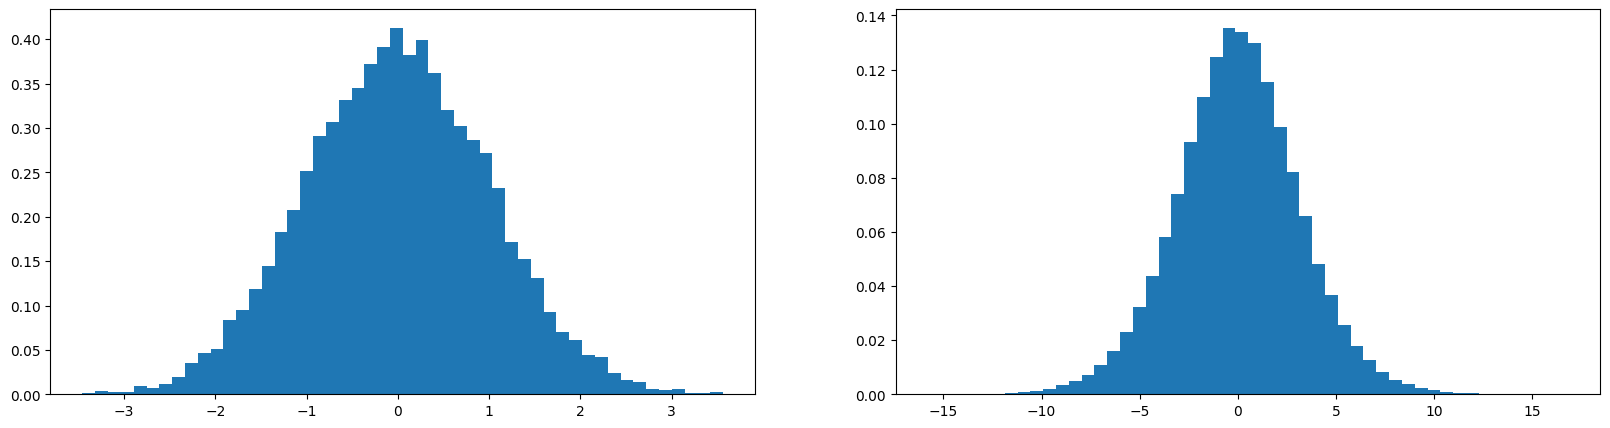

In [58]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

tensor(0.0152) tensor(1.0012)
tensor(-0.0021) tensor(1.0303)


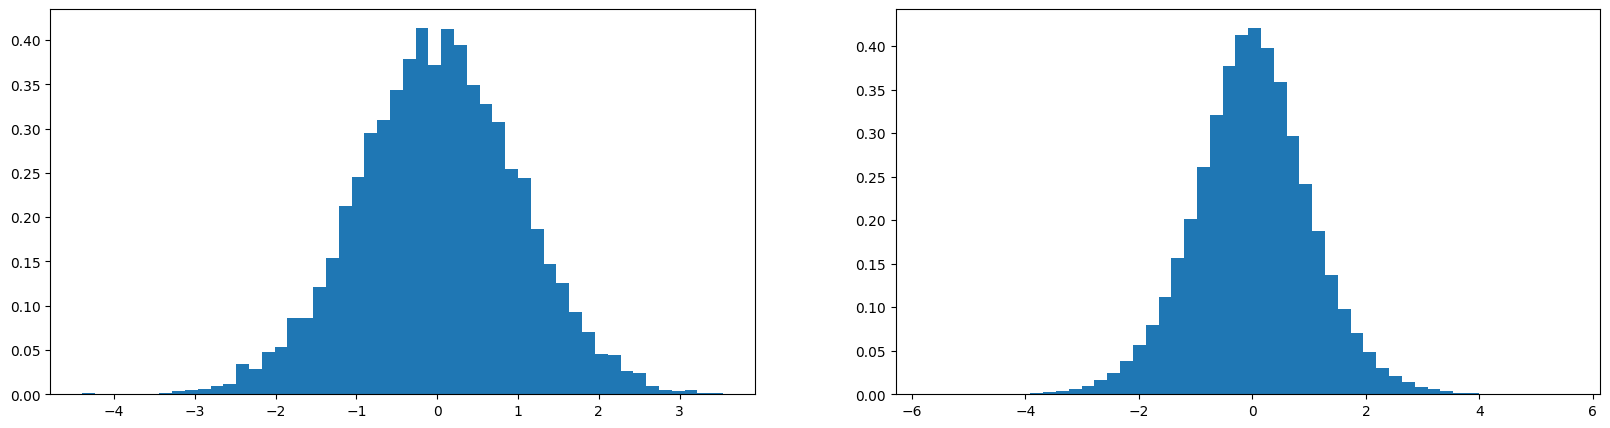

In [59]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

# 5) Batch normalization

In [60]:
n_embed = 10
n_hidden = 200

gain_W1 = (5/3) / (n_embed*block_size)**0.5
gain_W2 = (5/3) / (n_hidden)**0.5

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),           generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g).__mul__(gain_W1)
b1 = torch.randn((n_hidden),                     generator=g).__mul__(0.0)
W2 = torch.randn((n_hidden, vocab_size),         generator=g).__mul__(gain_W2)
b2 = torch.randn((vocab_size),                   generator=g).__mul__(0.0)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [61]:
batch_size = 32

# minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pas
emb = C[Xb]
emb_cat = emb.view(emb.shape[0], block_size*n_embed)
h_pre = emb_cat @ W1 + b1
h = torch.tanh(h_pre)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yb)

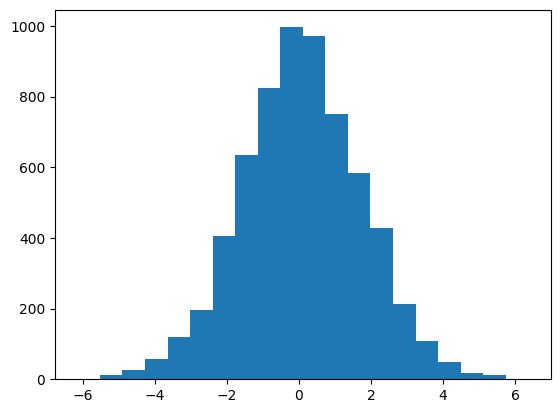

In [62]:
plt.hist(h_pre.view(-1).tolist(), bins=20);

In [65]:
n_embed = 10
n_hidden = 200

gain_W1 = (5/3) / (n_embed*block_size)**0.5
gain_W2 = (5/3) / (n_hidden)**0.5

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),           generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g).__mul__(gain_W1)
b1 = torch.randn((n_hidden),                     generator=g).__mul__(0.0)
W2 = torch.randn((n_hidden, vocab_size),         generator=g).__mul__(gain_W2)
b2 = torch.randn((vocab_size),                   generator=g).__mul__(0.0)

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [66]:
batch_size = 32

# minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pas
emb = C[Xb]
emb_cat = emb.view(emb.shape[0], block_size*n_embed)
h_pre = emb_cat @ W1 + b1
h_pre = bngain*(h_pre - h_pre.mean(0, keepdim=True)) / h_pre.std(0, keepdim=True) + bnbias
h = torch.tanh(h_pre)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yb)

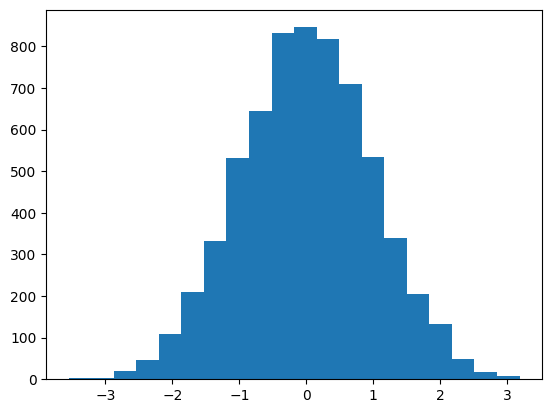

In [67]:
plt.hist(h_pre.view(-1).tolist(), bins=20);

# 6) Training using these tricks

In [81]:
n_embed = 10
n_hidden = 200

gain_W1 = (5/3) / (n_embed*block_size)**0.5
gain_W2 = (5/3) / (n_hidden)**0.5

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),           generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g).__mul__(gain_W1)
W2 = torch.randn((n_hidden, vocab_size),         generator=g).__mul__(gain_W2)
b2 = torch.randn((vocab_size),                   generator=g).__mul__(0.0)

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

      0 / 200000: 3.6882
   1000 / 200000: 2.3319
   2000 / 200000: 2.4799
   3000 / 200000: 2.2577
   4000 / 200000: 2.1448
   5000 / 200000: 2.2548
   6000 / 200000: 2.3690
   7000 / 200000: 2.3454
   8000 / 200000: 2.3736
   9000 / 200000: 2.1541
  10000 / 200000: 2.6325
  11000 / 200000: 1.9033
  12000 / 200000: 2.2766
  13000 / 200000: 2.0234
  14000 / 200000: 2.3495
  15000 / 200000: 2.3325
  16000 / 200000: 1.9059
  17000 / 200000: 2.3053
  18000 / 200000: 1.9641
  19000 / 200000: 2.5784
  20000 / 200000: 2.0234
  21000 / 200000: 2.0233
  22000 / 200000: 2.8532
  23000 / 200000: 2.5082
  24000 / 200000: 2.0748
  25000 / 200000: 2.5189
  26000 / 200000: 1.9826
  27000 / 200000: 2.3148
  28000 / 200000: 2.4669
  29000 / 200000: 2.0520
  30000 / 200000: 2.1088
  31000 / 200000: 2.4568
  32000 / 200000: 2.1781
  33000 / 200000: 2.1559
  34000 / 200000: 2.0809
  35000 / 200000: 2.3797
  36000 / 200000: 2.5452
  37000 / 200000: 2.3465
  38000 / 200000: 2.2357
  39000 / 200000: 2.2566


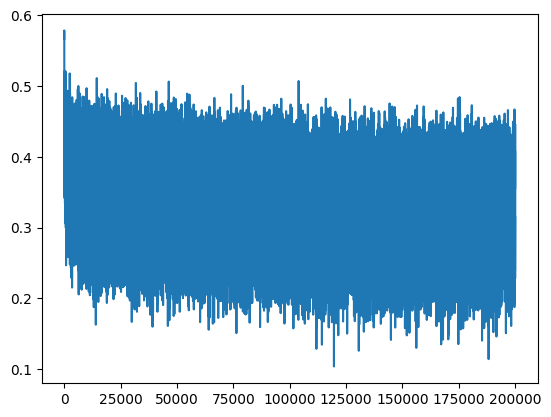

In [82]:
batch_size = 32
max_steps = 200000
stepi = []
lossi = []

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass - linear
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], block_size*n_embed)
    h_pre = emb_cat @ W1
    
    # forward pass - batch norm
    bnmeani = h_pre.mean(0, keepdim=True)
    bnstdi = h_pre.std(0, keepdim=True)
    h_pre = bngain*(h_pre - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
    
    # forward pass - non-linearity
    h = torch.tanh(h_pre)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
        
    # log stats
    if i % 1000 == 0:
        print(f'{i:7d} /{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)
plt.plot(stepi, lossi);

In [83]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    h_pre = embcat @ W1
    bnmean = h_pre.mean(0, keepdim=True)
    bnstd = h_pre.std(0, keepdim=True)

In [84]:
@torch.no_grad() 
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    h_pre = emb_cat @ W1
    h_pre = bngain*(h_pre - bnmean) / bnstd + bnbias
    h = torch.tanh(h_pre)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0718941688537598
val 2.1148438453674316


In [86]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)
for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        emb_cat = emb.view(emb.shape[0], -1)
        h_pre = emb_cat @ W1
        h_pre = bngain*(h_pre - bnmean) / bnstd + bnbias
        h = torch.tanh(h_pre)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

dexie.
moulius.
rochity.
kell.
imitta.
noluwak.
katha.
samiyah.
javer.
gotti.
moliselian.
keyreda.
kameria.
sadel.
niaviyah.
folst.
huniven.
tahlan.
kashra.
antil.


# 7) Torch-ify the code

In [200]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [201]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

In [202]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [203]:
n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
          layer.weight *= 0.5

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

46497


In [209]:
batch_size = 32
max_steps = 1000
stepi = []
lossi = []
ud = []

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
        
    # log stats
    if i % 1000 == 0:
        print(f'{i:7d} /{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)
    
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0 /   1000: 3.2865


layer 1 (      Tanh): mean -0.03, std 0.46, saturated: 0.06%
layer 3 (      Tanh): mean +0.00, std 0.32, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.28, saturated: 0.00%
layer 7 (      Tanh): mean -0.01, std 0.28, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.35, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

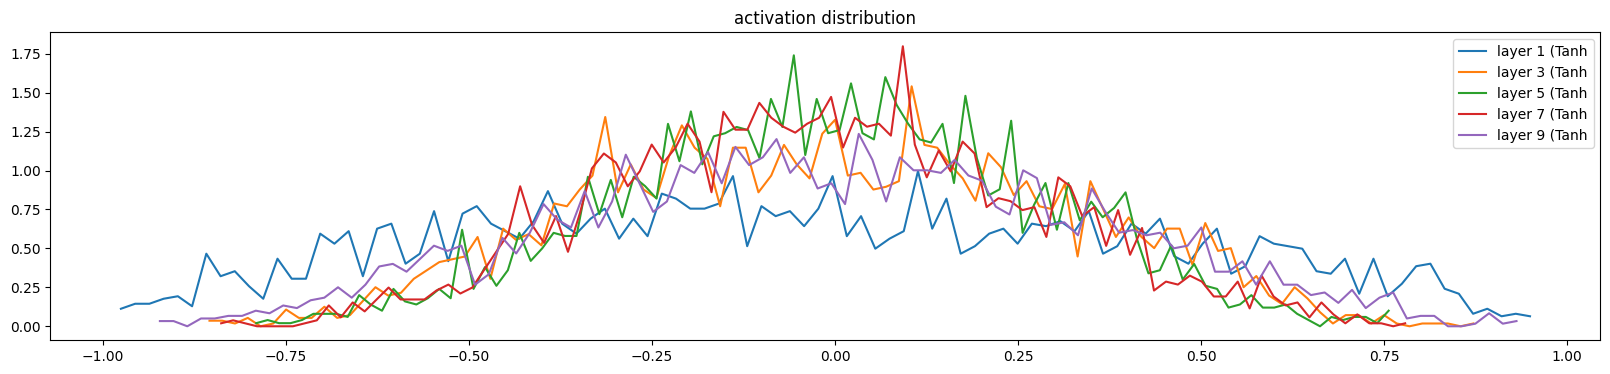

In [210]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution');

layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'gradients of the distribution')

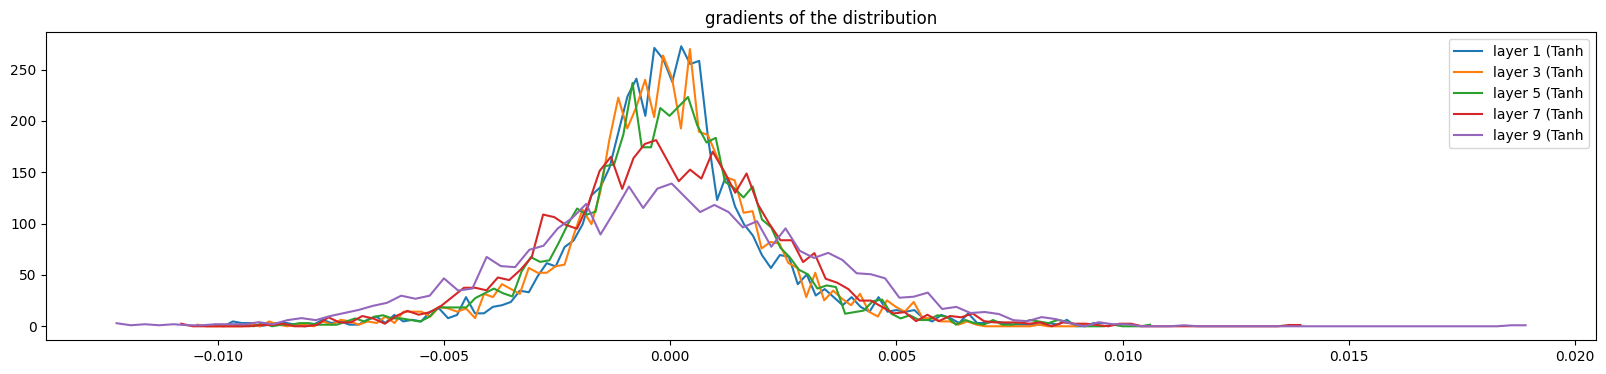

In [211]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradients of the distribution');

weight   (27, 10) | mean +0.000640 | std 9.225056e-03 | grad:data ratio 9.162419e-03
weight  (30, 100) | mean -0.000243 | std 1.111573e-02 | grad:data ratio 1.085111e-01
weight (100, 100) | mean -0.000012 | std 6.045796e-03 | grad:data ratio 1.119233e-01
weight (100, 100) | mean -0.000018 | std 4.368355e-03 | grad:data ratio 8.123456e-02
weight (100, 100) | mean +0.000044 | std 4.179772e-03 | grad:data ratio 7.783142e-02
weight (100, 100) | mean -0.000067 | std 5.344293e-03 | grad:data ratio 9.727877e-02
weight  (100, 27) | mean -0.000000 | std 1.350331e-02 | grad:data ratio 1.208089e-01


Text(0.5, 1.0, 'weights gradient distribution')

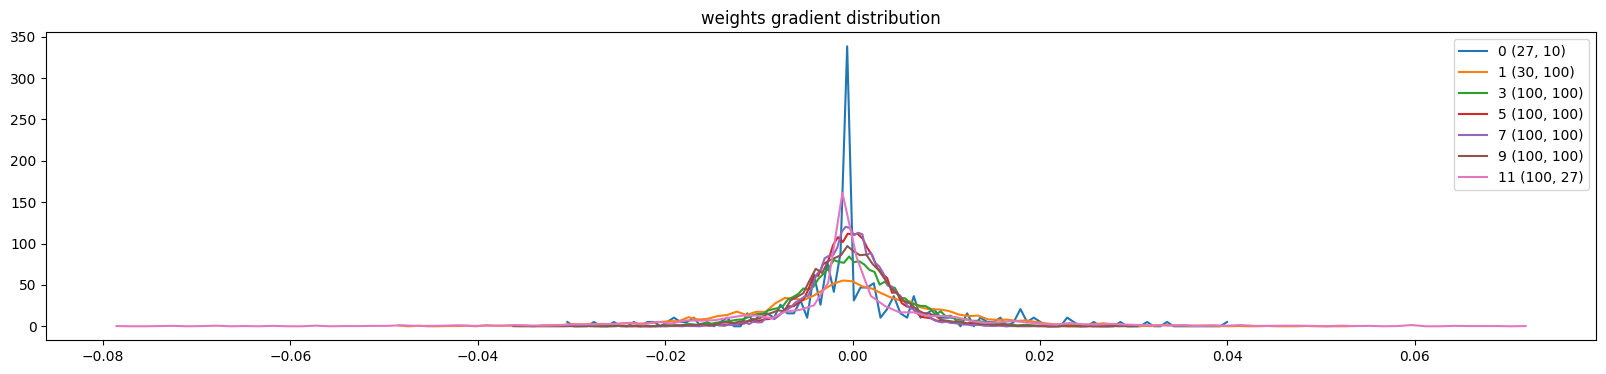

In [212]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distribution');

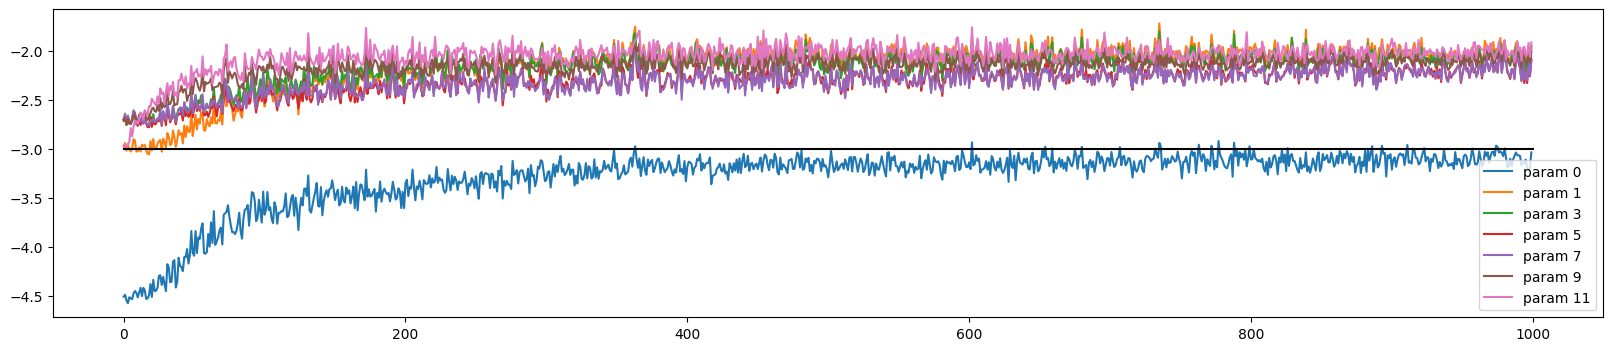

In [214]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);

# 8) Adjusting the initial weights (Kaiming)

In [215]:
n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
          layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

46497


In [216]:
batch_size = 32
max_steps = 1000
stepi = []
lossi = []
ud = []

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
        
    # log stats
    if i % 1000 == 0:
        print(f'{i:7d} /{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)
    
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0 /   1000: 3.5237


layer 1 (      Tanh): mean -0.04, std 0.77, saturated: 21.81%
layer 3 (      Tanh): mean -0.02, std 0.72, saturated: 11.75%
layer 5 (      Tanh): mean +0.02, std 0.74, saturated: 13.03%
layer 7 (      Tanh): mean -0.03, std 0.73, saturated: 11.78%
layer 9 (      Tanh): mean -0.03, std 0.72, saturated: 10.94%


Text(0.5, 1.0, 'activation distribution')

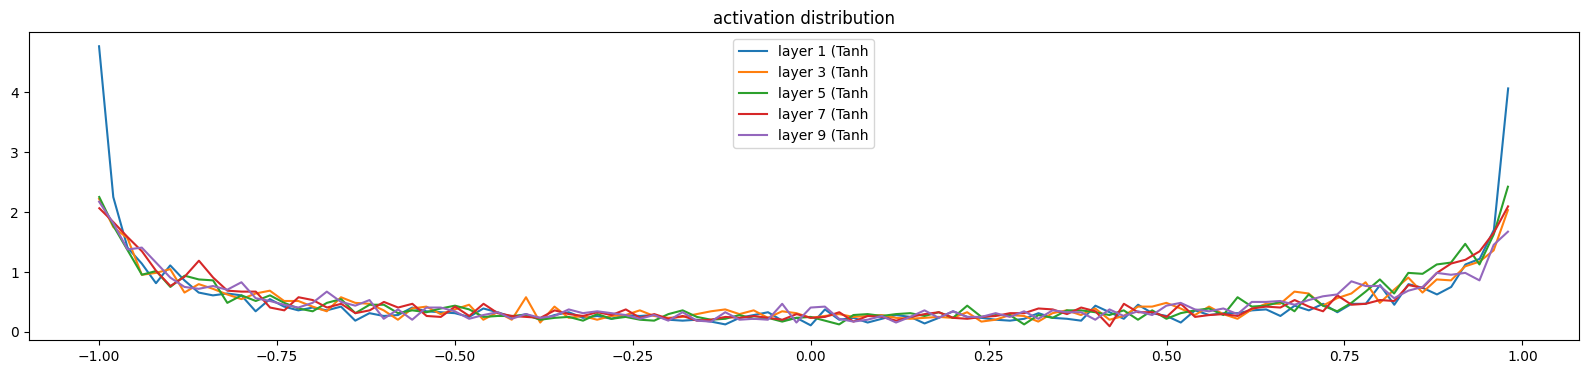

In [217]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution');

layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'gradients of the distribution')

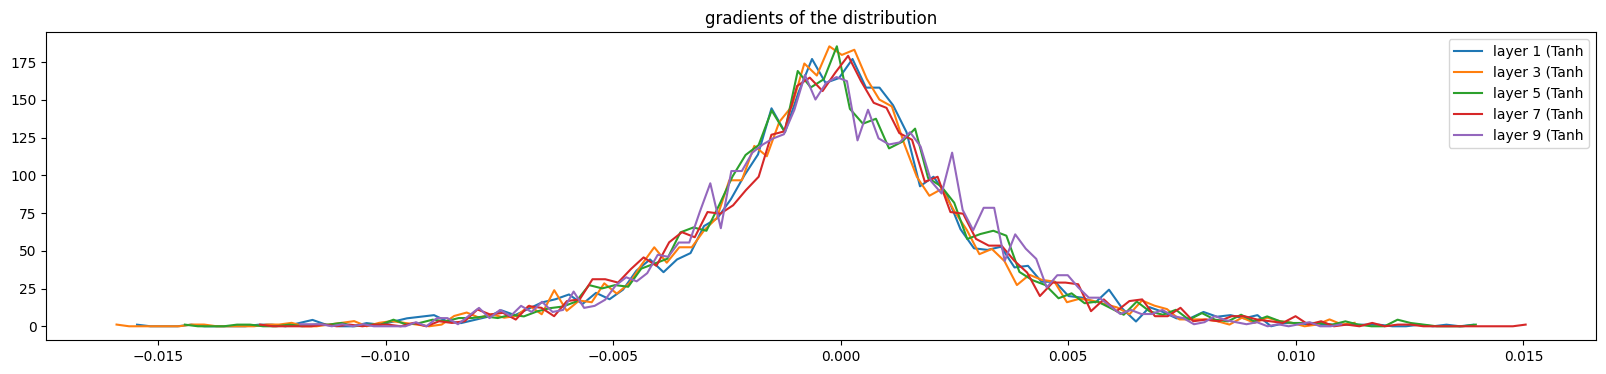

In [218]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradients of the distribution');

weight   (27, 10) | mean +0.000361 | std 1.285232e-02 | grad:data ratio 1.282169e-02
weight  (30, 100) | mean -0.000068 | std 9.696537e-03 | grad:data ratio 3.089262e-02
weight (100, 100) | mean +0.000202 | std 8.191954e-03 | grad:data ratio 4.854351e-02
weight (100, 100) | mean -0.000048 | std 7.918512e-03 | grad:data ratio 4.662103e-02
weight (100, 100) | mean +0.000002 | std 7.870150e-03 | grad:data ratio 4.664737e-02
weight (100, 100) | mean -0.000039 | std 7.923895e-03 | grad:data ratio 4.719049e-02
weight  (100, 27) | mean -0.000000 | std 2.404553e-02 | grad:data ratio 2.279378e-01


Text(0.5, 1.0, 'weights gradient distribution')

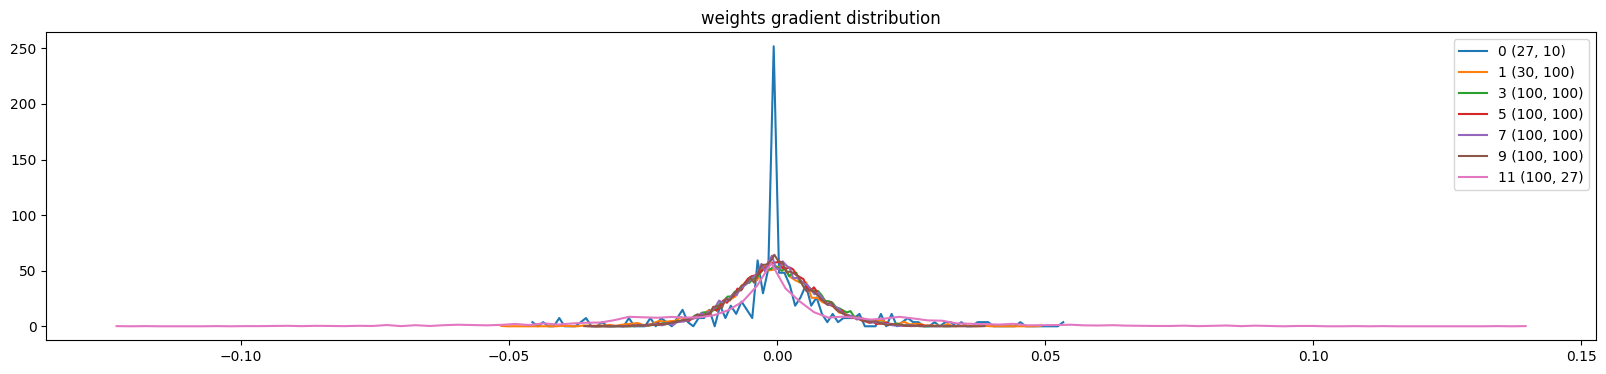

In [219]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distribution');

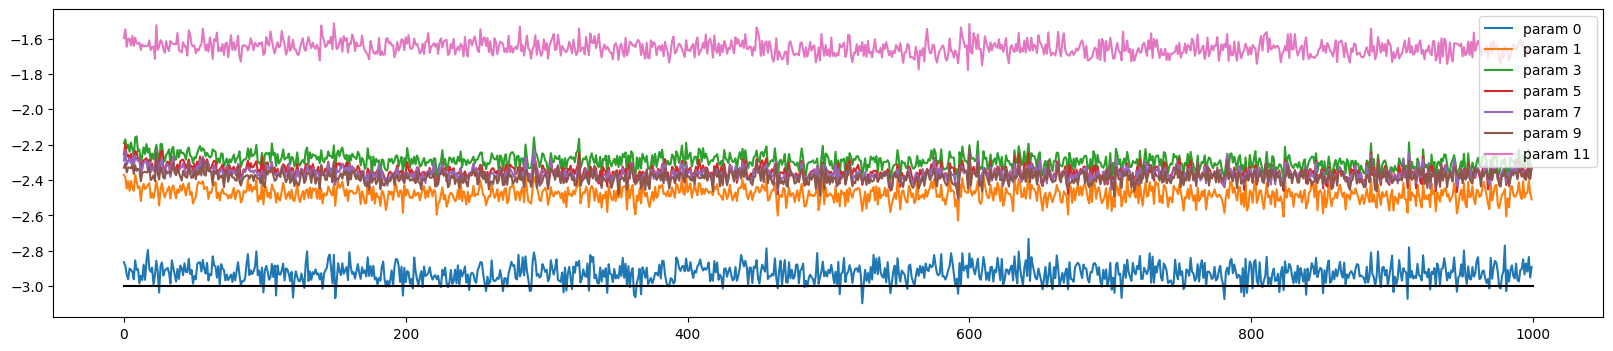

In [220]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);

# 9) Using batchnorm

In [227]:
n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed * block_size, n_hidden,   bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden,   bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden,   bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden,   bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden,   bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
          layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

47024


In [228]:
batch_size = 32
max_steps = 1000
stepi = []
lossi = []
ud = []

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
        
    # log stats
    if i % 1000 == 0:
        print(f'{i:7d} /{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)
    
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0 /   1000: 3.3055


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 2.75%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.84%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.53%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 2.38%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.66%


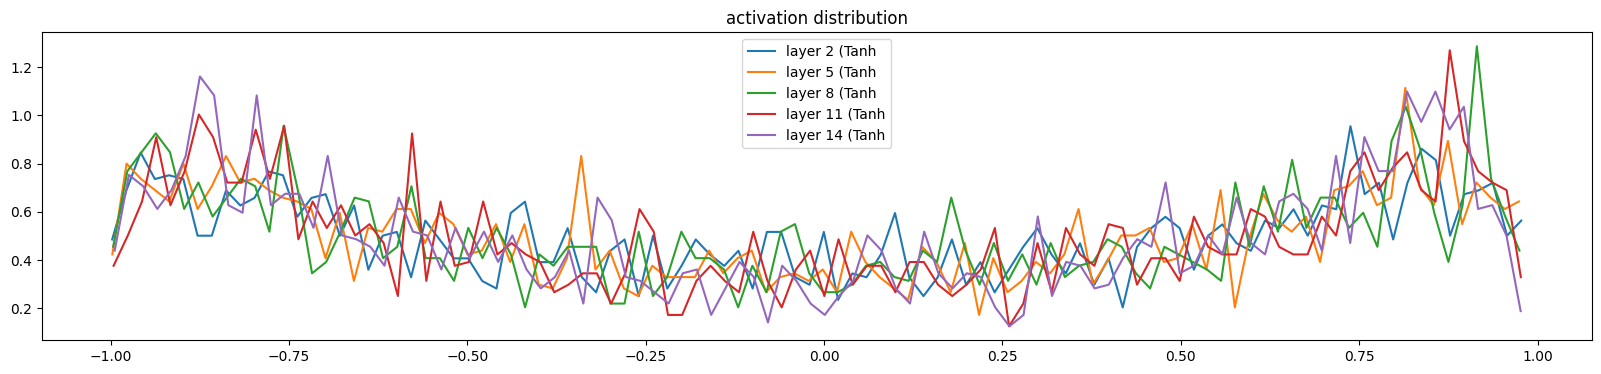

In [229]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution');

layer 2 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


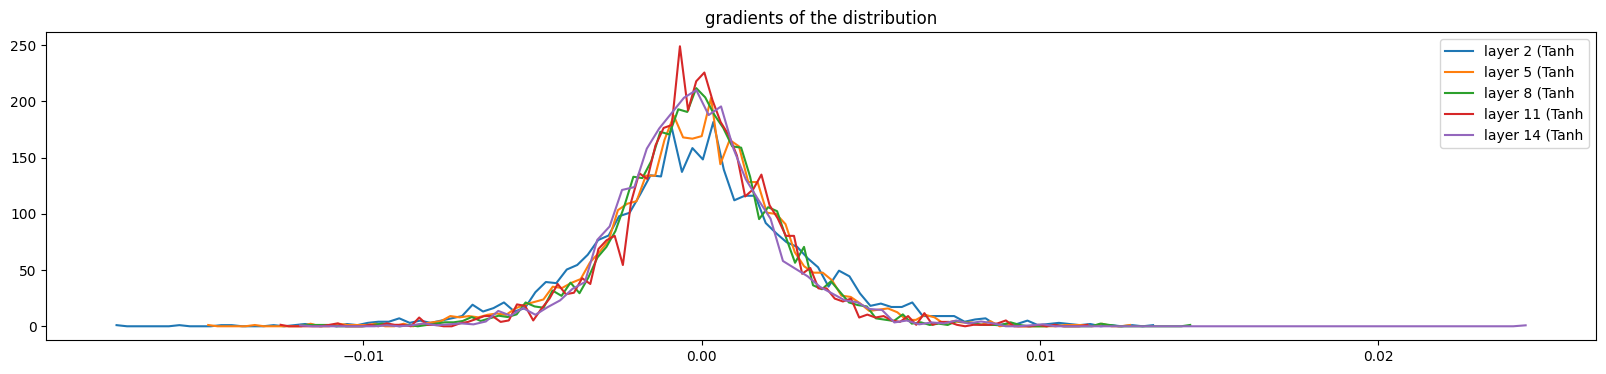

In [230]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradients of the distribution');

weight   (27, 10) | mean +0.000000 | std 6.905522e-03 | grad:data ratio 6.898579e-03
weight  (30, 100) | mean -0.000059 | std 6.225124e-03 | grad:data ratio 1.991996e-02
weight (100, 100) | mean +0.000089 | std 6.036785e-03 | grad:data ratio 3.612744e-02
weight (100, 100) | mean -0.000007 | std 5.111746e-03 | grad:data ratio 3.032015e-02
weight (100, 100) | mean -0.000041 | std 4.568172e-03 | grad:data ratio 2.722334e-02
weight (100, 100) | mean -0.000014 | std 4.153580e-03 | grad:data ratio 2.474210e-02
weight  (100, 27) | mean -0.000061 | std 8.479953e-03 | grad:data ratio 5.089739e-02


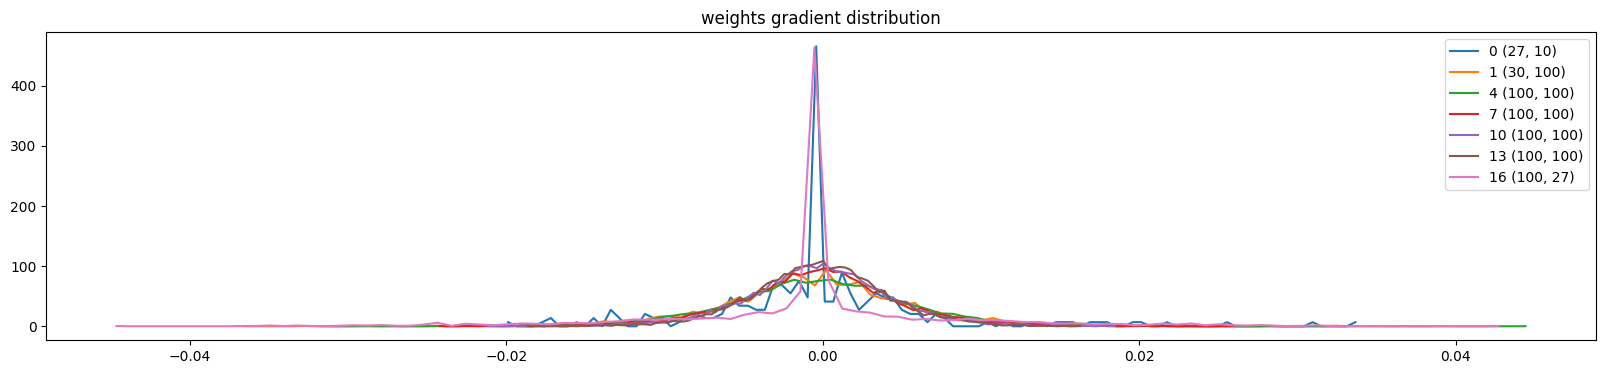

In [231]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distribution');

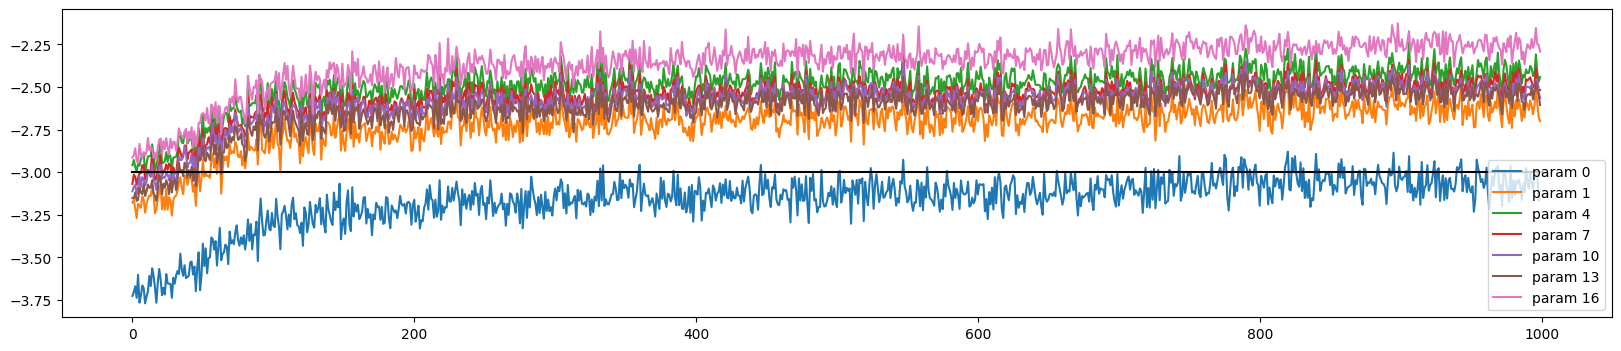

In [232]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);